In [1]:
import scipy.io as sio
import numpy as np
import mat73
import center_algorithms as ca
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
from sklearn.manifold import MDS


In [2]:
n_its= 10
seed = 0

labels_raw = sio.loadmat('./data/kmeans_action_labels.mat')['kmeans_action_labels']

labels_true = [l[0][0] for l in labels_raw['labels'][0][0]]
# labelidxs =labels_raw['labelidxs'][0][0][0]


raw_data = mat73.loadmat('./data/kmeans_pts.mat')

X = [t[0] for t in raw_data['Data']['gr_pts']]

print(len(X))
X[0].shape

601


(1024, 48)

In [3]:
label_counts = {}
for l in labels_true:
    label_counts[l] = len(np.where(np.array(labels_true) == l)[0])
label_counts

{'push-cart': 20,
 'clap-group': 41,
 'ride-bike': 17,
 'swing': 3,
 'follow': 32,
 'flap': 11,
 'loiter': 185,
 'bend': 27,
 'run': 24,
 'point-group': 33,
 'cart-motion': 9,
 'stand': 5,
 'pickup': 27,
 'gesture': 39,
 'run-group': 4,
 'walk-rifle': 7,
 'loiter-group': 117}

In [4]:
idx = []
for the_labels in ['run', 'pickup', 'bend','follow', 'ride-bike']:
# for the_labels in ['run', 'stand', 'pickup']:
# for the_labels in ['run', 'stand', 'walk-rifle']: #for winning sine median
    idx += list(np.where(np.array(labels_true) == the_labels)[0])

In [5]:
labels_true = [labels_true[i] for i in idx]
X = [X[i] for i in idx]
labels_true

['run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'run',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'pickup',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'bend',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'follow',
 'fo

In [6]:

'''
datapoints rows and centers columns

sine
cosine
sine_sq
'''
def distance_matrix(X, C, opt_type = 'sine'):
    n = len(X)
    m = len(C)
    Distances = np.zeros((m,n))

    # if opt_type == 'cosine':
    #     opt_type = 'sinesq'
    opt_type = 'sine'

    for i in range(m):
        for j in range(n):
            Distances[i,j] = ca.calc_error_1_2([C[i]], X[j], opt_type)
            
    return Distances

def cluster_purity(X, centers, opt_type, labels_true):
    #calculate distance matrix
    d_mat = distance_matrix(X, centers, opt_type)

    #find the closest center for each point
    index = np.argmin(d_mat, axis = 0)
    
    count = 0
    for i in range(len(centers)):
        idx = np.where(index == i)[0]
        cluster_labels = [labels_true[i] for i in idx]
        most_common_label = max(set(cluster_labels), key = cluster_labels.count)
        # count += cluster_labels.count(most_common_label)
        count += cluster_labels.count(most_common_label)/len(idx)

    # return count/len(X)
    return count/len(centers)

In [7]:

def lbg_subspace(X, epsilon, n_centers = 17, opt_type = 'sine', n_its = 10, seed = 1):
    n_pts = len(X)
    error = 1
    r = 48
    distortions = []

    #init centers
    np.random.seed(seed)
    centers = []
    for i in range(n_centers):
        centers.append(X[np.random.randint(n_pts)])

    #calculate distance matrix
    d_mat = distance_matrix(X, centers, opt_type)

    #find the closest center for each point
    index = np.argmin(d_mat, axis = 0)

    #calculate first distortion
    new_distortion = np.sum(d_mat[index])

    distortions.append(new_distortion)


    errors = []
    while error > epsilon:

        #set new distortion as old one
        old_distortion = new_distortion

        m = len(centers)

        #calculate new centers
        centers = []
        for c in range(m):
            idx = np.where(index == c)[0]
            if len(idx) > 0:
                if opt_type == 'sinesq':
                    centers.append(ca.flag_mean([X[i] for i in idx], r, fast = False))
                else:
                    centers.append(ca.irls_flag([X[i] for i in idx], r, n_its, opt_type, opt_type)[0])
        #         centers.append(np.mean([X[i] for i in idx], axis = 0))

        #calculate distance matrix
        d_mat = distance_matrix(X, centers, opt_type)

        #find the closest center for each point
        index = np.argmin(d_mat, axis = 0)

        #new distortion
        new_distortion = np.sum(d_mat[index])

        distortions.append(new_distortion)

        if new_distortion <0.00000000001:
            error = 0
        else:
            error = np.abs(new_distortion - old_distortion)/old_distortion
        errors.append(error)
        print(error)

    return centers, errors, distortions





In [8]:
Purities = pandas.DataFrame(columns = ['Algorithm','Number of Clusters','Cluster Purity'])

n=10

sin_purities = []
cos_purities = []
flg_purities = []
for trial in range(1):
    print('.')
    print('.')
    print('.')
    print('sin start')
    centers_sin, error_sin, dist_sin = lbg_subspace(X, .00001, n_centers = n, opt_type = 'sine', n_its = 10, seed = trial)
    sin_purity = cluster_purity(X, centers_sin, 'sine', labels_true)
    print('cos start')
    centers_cos, error_cos, dist_cos = lbg_subspace(X, .00001, n_centers = n, opt_type = 'cosine', n_its = 10, seed = trial)
    cos_purity = cluster_purity(X, centers_cos, 'cosine', labels_true)
    print('flg start')
    centers_flg, error_flg, dist_flg = lbg_subspace(X, .00001, n_centers = n, opt_type = 'sinesq', seed = trial)
    flg_purity = cluster_purity(X, centers_flg, 'sinesq', labels_true)


    Purities = Purities.append({'Algorithm': 'Sine Median', 
                            'Number of Clusters': n,
                            'Cluster Purity': sin_purity},
                            ignore_index = True)
    Purities = Purities.append({'Algorithm': 'Maximum Cosine', 
                            'Number of Clusters': n,
                            'Cluster Purity': cos_purity},
                            ignore_index = True)
    Purities = Purities.append({'Algorithm': 'Flag Mean', 
                            'Number of Clusters': n,
                            'Cluster Purity': flg_purity},
                            ignore_index = True)


.
.
.
sin start
11
8
8
11
11
9
11
7
8
0.022944636244148775
11
8
8
3
11
9
11
7
8
4.933284405646243e-05
11
8
8
3
11
9
11
7
8
0.0
cos start
11
11
11
3
3
11
11
11
11
0.022507957928729033
11
11
11
3
3
11
11
11
11
0.0
flg start
0.022512671925215635
0.00012752398836358153
0.0


In [9]:
Purities

,Algorithm,Number of Clusters,Cluster Purity
0,Sine Median,10,0.494820
1,Maximum Cosine,10,0.512626
2,Flag Mean,10,0.518799


'pickup'

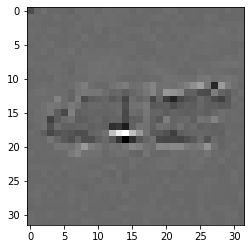

In [10]:
sample = 30
plt.imshow(X[sample][:,24].reshape(32,32), cmap='gray')
labels_true[sample]

In [11]:
d_mat = distance_matrix(X, centers_sin, 'sine')
#find the closest center for each point
index = np.argmin(d_mat, axis = 0)
s_idx = index[sample]

d_mat = distance_matrix(X, centers_cos, 'sine')
#find the closest center for each point
index = np.argmin(d_mat, axis = 0)
c_idx = index[sample]

d_mat = distance_matrix(X, centers_flg, 'sine')
#find the closest center for each point
index = np.argmin(d_mat, axis = 0)
f_idx = index[sample]

Text(0.5, 1.0, 'Flag Mean')

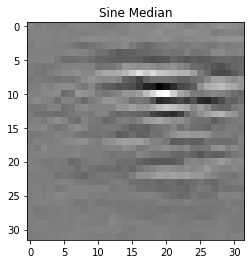

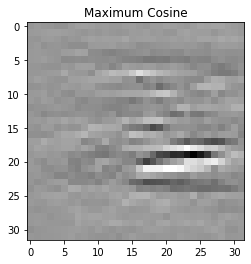

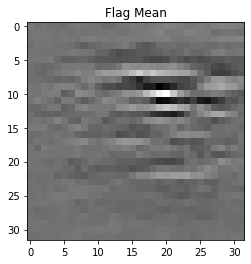

In [15]:
plt.figure()
plt.imshow(centers_sin[s_idx][:,15].reshape(32,32), cmap='gray')
plt.title('Sine Median')
plt.figure()
plt.imshow(-centers_cos[c_idx][:,15].reshape(32,32), cmap='gray')
plt.title('Maximum Cosine')
plt.figure()
plt.imshow(centers_flg[f_idx][:,15].reshape(32,32), cmap='gray')
plt.title('Flag Mean')

'pickup'

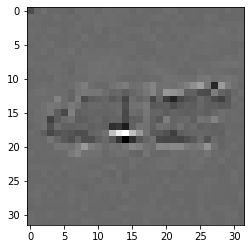